In [1]:
###Import Packages###
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from skimage import io, color

import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from gensim.models import Word2Vec
import string

import re


##Upload Data and unzip them

In [2]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [72]:
# basedir = "/content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/"
basedir = "/content/drive/MyDrive/CV_Final_Project_Data/data/"
# basedir = "/content/"

df = pd.read_csv(f'{basedir}annot.csv', low_memory = False)
# Remove rows contains only single period
df = df[df.utf8_string != "."]
# Remove all punctuations
df["utf8_string"] = df["utf8_string"].str.replace('[^\w\s]','',regex=True)
df=df.reset_index(drop=True)
print(df.tail())
df.shape

        Unnamed: 0                   id          image_id  \
714765     1052347  0ebbecdc46b78d42_13  0ebbecdc46b78d42   
714766     1052348  0ebbecdc46b78d42_14  0ebbecdc46b78d42   
714767     1052350   a37e1fb026b80a6d_1  a37e1fb026b80a6d   
714768     1052351   a37e1fb026b80a6d_2  a37e1fb026b80a6d   
714769     1052352   a37e1fb026b80a6d_3  a37e1fb026b80a6d   

                                    bbox utf8_string  \
714765   [507.16, 273.18, 100.7, 135.01]           7   
714766  [387.77, 149.05, 104.33, 127.75]           8   
714767  [331.69, 462.84, 417.31, 201.08]         RÖR   
714768    [876.75, 285.63, 36.98, 10.28]     Moderna   
714769    [913.53, 282.86, 32.23, 11.27]      Museet   

                                                   points      area  
714765  [507.16, 273.46, 607.86, 273.18, 606.19, 407.9...  13595.51  
714766  [387.77, 149.05, 492.1, 149.6, 491.26, 276.8, ...  13328.16  
714767  [331.69, 466.97, 749.0, 462.84, 749.0, 659.79,...  83912.69  
714768  [876.75,

(714770, 7)

In [73]:
dir_list = os.listdir('/content/drive/MyDrive/CV_Final_Project_Data/data/train_val_images/train_images')
# convert to numpy
dir_list = np.array(dir_list)
print(dir_list.shape)
# convert image_id to numpy
image_id_list = df.image_id.tolist()
# add .jpg to the end of each element
random_list = [x + '.jpg' for x in image_id_list]
random_list = np.array(random_list)
random_list = np.unique(random_list)
# match image_id with dir_list, delete the rows that do not match
dir_list = np.intersect1d(dir_list, random_list)
random_list.shape
# remove .jpg from dir_list
dir_list = [x[:-4] for x in dir_list]

(2907,)


In [74]:
print(dir_list)

['000209d575f3aa4f', '0002cb8d8ea5eb7e', '00068a9d975dcc8a', '000bb81adefe7332', '000e97147fa9e763', '0010f4c10f7ab07e', '001156eb13f37194', '00130c2588695b00', '0017b872c4ad04c7', '001f5618a7b33d88', '00214a12ff8112fb', '0024646120c939de', '002550d790ed010c', '002790511b9920a5', '0027c1c20a989257', '0028cfeb1d0ec7ce', '0029cb5bf907f89e', '0029d81d0f4ac3d0', '002a76c5142a4b1c', '002ed4b2e22b51e6', '00325fc8496cde98', '00326537f57449d0', '0038c797a3708652', '003b73b07cfb6d58', '003e8ba237cc7842', '00415a985d812ecd', '00453fcb4e869350', '0045f0e526dcf63b', '004629d0dcad55df', '00462a09546c3df2', '004b1e697e3ffdf9', '004c316ee7c0a3fc', '004e59f30392a1cc', '004f1ec7d27bb12d', '0052c92026c934e5', '00545ded62f5d8e0', '00548dfc8ec76f5d', '005579186e95c20a', '0055f3b771d53fe2', '00560c3045b4f1d5', '005635e119b9f32f', '00565e236c7c8f5f', '00594e9c5e6d67b6', '0059b3476be49c49', '0059b85f053a2e64', '005a2a34b7a0e507', '005cdc41f47be514', '0060bd3d509fba0f', '006500d2b983306e', '0069ec40a8a43caa',

In [75]:
df = df[df['image_id'].isin(dir_list)]

In [79]:
df = df.reset_index(drop=True)

In [76]:
df.shape

(80009, 7)

In [77]:
df['image_id']=df['image_id'].astype('str')
import ast
df["bbox"] = df["bbox"].apply(ast.literal_eval)

In [80]:
type(df['bbox'][0][0])

float

In [81]:
print(df['bbox'][0][0])

323.75


In [88]:
print(df.iloc[25,:])

Unnamed: 0                                                  1069
id                                            8fffa9f900e37e77_2
image_id                                        8fffa9f900e37e77
bbox                              [279.91, 217.68, 51.27, 11.75]
utf8_string                                                 orca
points         [280.24, 219.17, 331.18, 217.68, 330.52, 229.1...
area                                                      602.42
Name: 25, dtype: object


In [117]:
df.columns

Index(['Unnamed: 0', 'id', 'image_id', 'bbox', 'utf8_string', 'points',
       'area'],
      dtype='object')

In [119]:
df = df.drop('Unnamed: 0', axis=1)

In [120]:
df.to_csv("/content/drive/MyDrive/CV_Final_Project_Data/data/annot.csv")

#Loader

In [121]:
h_list=[]
w_list=[]
for i in range(len(df)): #len(df)
  # print(df['image_id'][i])
  # pth=basedir+'train_val_images/train_images/'+df['image_id'][i]+'.jpg'
  bbox=df['bbox'][i]
  # print(bbox)
  # print(bbox[2],bbox[3])
  h_list.append(bbox[2])
  w_list.append(bbox[3])
print(max(h_list),min(h_list))
print(max(w_list),min(w_list))

1016.46 2.1
799.7 2.81


In [144]:
def pad_img(path, bbox=None):
  # read image
  img = Image.open(path)
  img = np.array(img)
  print(img.shape)
  if bbox != None:
    #top_left = [min(bbox[1], bbox[3]), min(bbox[0], bbox[2])]
    #bottom_right  = [max(bbox[1], bbox[3]), max(bbox[0], bbox[2])]
    top_left = [bbox[1], bbox[0]]
    bottom_right = [bbox[1]+bbox[3], bbox[0]+bbox[2]]
    img = img[ top_left[0]:bottom_right[0], top_left[1]:bottom_right[1] ] 
  old_image_height, old_image_width, channels = img.shape
  print(img.shape)

  # create new image of desired size and color (blue) for padding
  new_image_width = 1024   # max height 1023.51  min 2.1
  new_image_height = 1024   # max width 910.98   min 1.9

  color = (0,0,0)
  result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)

  result[0:old_image_height, 0:old_image_width] = img

  return result

(681, 1024, 3)
(128, 104, 3)


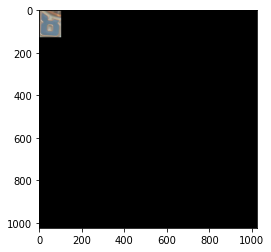

In [145]:
imgp = pad_img(f'{basedir}train_val_images/train_images/0ebbecdc46b78d42.jpg', [388, 149, 104, 128]	)
#imgp = pad_img(f'{basedir}train_val_images/train_images/a4ea732cd3d5948a.jpg')
plt.imshow(imgp)
plt.show()

In [115]:
blah_df = pd.read_csv("/content/drive/MyDrive/CV_Final_Project_Data/data/annot.csv", low_memory = False)

In [116]:
blah_df.head()

,Unnamed: 0,Unnamed: 0.1,id,image_id,bbox,utf8_string,points,area
0,0,472,6e39569903a669f5_1,6e39569903a669f5,"[323.75, 169.49, 95.6, 51.06]",ASUS,"[335.7, 169.49, 419.35, 196.65, 406.31, 220.55...",4881.34
1,1,474,6e39569903a669f5_3,6e39569903a669f5,"[172.74, 275.96, 49.98, 36.93]",Android,"[183.61, 275.96, 222.72, 294.42, 215.11, 312.8...",1845.76
2,2,475,6e39569903a669f5_4,6e39569903a669f5,"[212.94, 294.42, 35.85, 26.08]",Wear,"[215.11, 294.42, 248.79, 307.46, 242.27, 320.5...",934.97
3,3,476,6e39569903a669f5_5,6e39569903a669f5,"[243.36, 300.94, 60.84, 40.2]",ZenWatch,"[254.22, 300.94, 304.2, 321.58, 295.5, 341.14,...",2445.77
4,4,477,6e39569903a669f5_6,6e39569903a669f5,"[295.5, 320.5, 29.34, 23.9]",Ma,"[299.85, 320.5, 324.84, 332.45, 318.32, 344.4,...",701.23


In [ ]:
# def pad_text(text, max_len=30):
    # add an underline to text to make all text equal to 50 characters
    # text = text + ' ' * (max_len - len(text))
    # return texta

In [178]:
# Text OCR Dataloader 
import ast
from torch.autograd import Variable
rest_set_size = 0.3
test_set_size = 0.5
class dset(Dataset):
  def __init__(self, root_dir, train=True,test=True,transformX = None, transformY = None):
        #self.pixel_file = pd.read_csv(os.path.join(root_dir, 'sample.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        self.test = test


        annot_df = pd.read_csv(f'{self.root_dir}annot.csv', low_memory = False)
        # # Remove rows contains only single period
        # annot_df = annot_df[annot_df.utf8_string != "."]
        # # Reset index
        # annot_df=annot_df.reset_index(drop=True)
        # Remove all punctuations
        annot_df["utf8_string"] = annot_df["utf8_string"].str.replace('[^\w\s]','',regex=True)
        # convert bbox to float list
        annot_df["bbox"] = annot_df["bbox"].apply(ast.literal_eval)
        # 70% tain, 15% valid, 15% test
        self.train_data, self.rest_data = train_test_split(annot_df, test_size = rest_set_size, random_state = 5)
        self.validation_data, self.test_data = train_test_split(annot_df, test_size = test_set_size, random_state = 5)

  def __len__(self):
    if self.train:
      length = len(self.train_data)
    elif self.test:
      length = len(self.test_data)
    else:
      length = len(self.validation_data)
    return length
  

  # for now, this will return:
  # X: the image (padded)
  # Y: encoded label
  def __getitem__(self, index):
    # retrieve row "image_id" from column index 2
    # Also retrieve bbox coordinates from column index 3
    filename = ""
    bbox = []
    
    if self.train:
      filename = self.train_data.iloc[index,2]
      bbox = [int(x) for x in self.train_data.iloc[index,3]]
    elif self.test:
      filename = self.test_data.iloc[index,2]
      #sliced = self.test_data.iloc[index,3][1:-1].split(", ")
      #bbox = [int(x) for x in sliced]
      bbox = [int(x) for x in self.test_data.iloc[index,3]]
    else:
      filename = self.validation_data.iloc[index,2]
      #sliced = self.validation_data.iloc[index,3][1:-1].split(", ")
      #bbox = [int(x) for x in sliced]
      bbox = [int(x) for x in self.validation_data.iloc[index,3]]


    imx = pad_img(f'{self.root_dir}train_val_images/train_images/{filename}.jpg', bbox)


    if self.train:
      text = self.train_data.iloc[index,4]
    elif self.test:
      text = self.test_data.iloc[index,4]
    else:
      text = self.validation_data.iloc[index,4]
    
    # for each letter/digit in text, map them into an integer value between 0 to 36
    # 00-09: 0-9
    # 10-35: A-Z
    # add a 36 in between each word
    int_text = []
    new_text = re.sub(r'[^\w\s]','',str(text))
    new_text = new_text.split()
    length = len(new_text)
    n = ''
    # print(new_text, type(new_text))
    # for t in new_text:
    #   # print(t)
    #   temp_text = []
    #   for i in range(len(t)):
    #     # print(t[i])
    #     if t[i].isdigit():
    #       n = int(t[i])
    #     elif t[i].isalpha():
    #       n = int(ord(t[i].upper()) - 55)
    #     # if i == length - 1:
    #     #   n = 37
    #     temp_text.append(n)
    #   int_text.append(temp_text)


    alphabet = '0123456789abcdefghijklmnopqrstuvwxyz'
    encoder=strLabelConverter(alphabet)
    int_text = encoder.encode(text)
    # int_text = Variable(int_text.to_tensor())
    # sample = {'image': imx, 'annotation': annot, 'text': vec_arr}
    int_text = torch.IntTensor(int_text[0])
    sample = {'image': imx, 'text': text, 'int_text': int_text}
    return sample

#path = '/content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/train_val_images/train_images/00c359f294f7dcd9.jpg'
#img = pad_img(path)


(682, 1024, 3)
(18, 26, 3)
ICF
tensor([19, 13, 16], dtype=torch.int32)


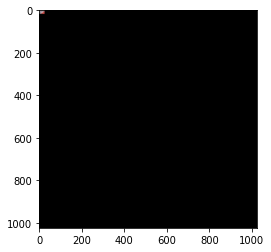

In [179]:
# basedir = "/content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/"
OCRdata = dset(basedir, train=True,test=False,)
data = OCRdata.__getitem__(20)

plt.imshow(data['image'])
print(data['text'])
print(data['int_text'])

(1024, 685, 3)
(26, 111, 3)
ALLIANCE
tensor([11, 22, 22, 19, 11, 24, 13, 15], dtype=torch.int32)


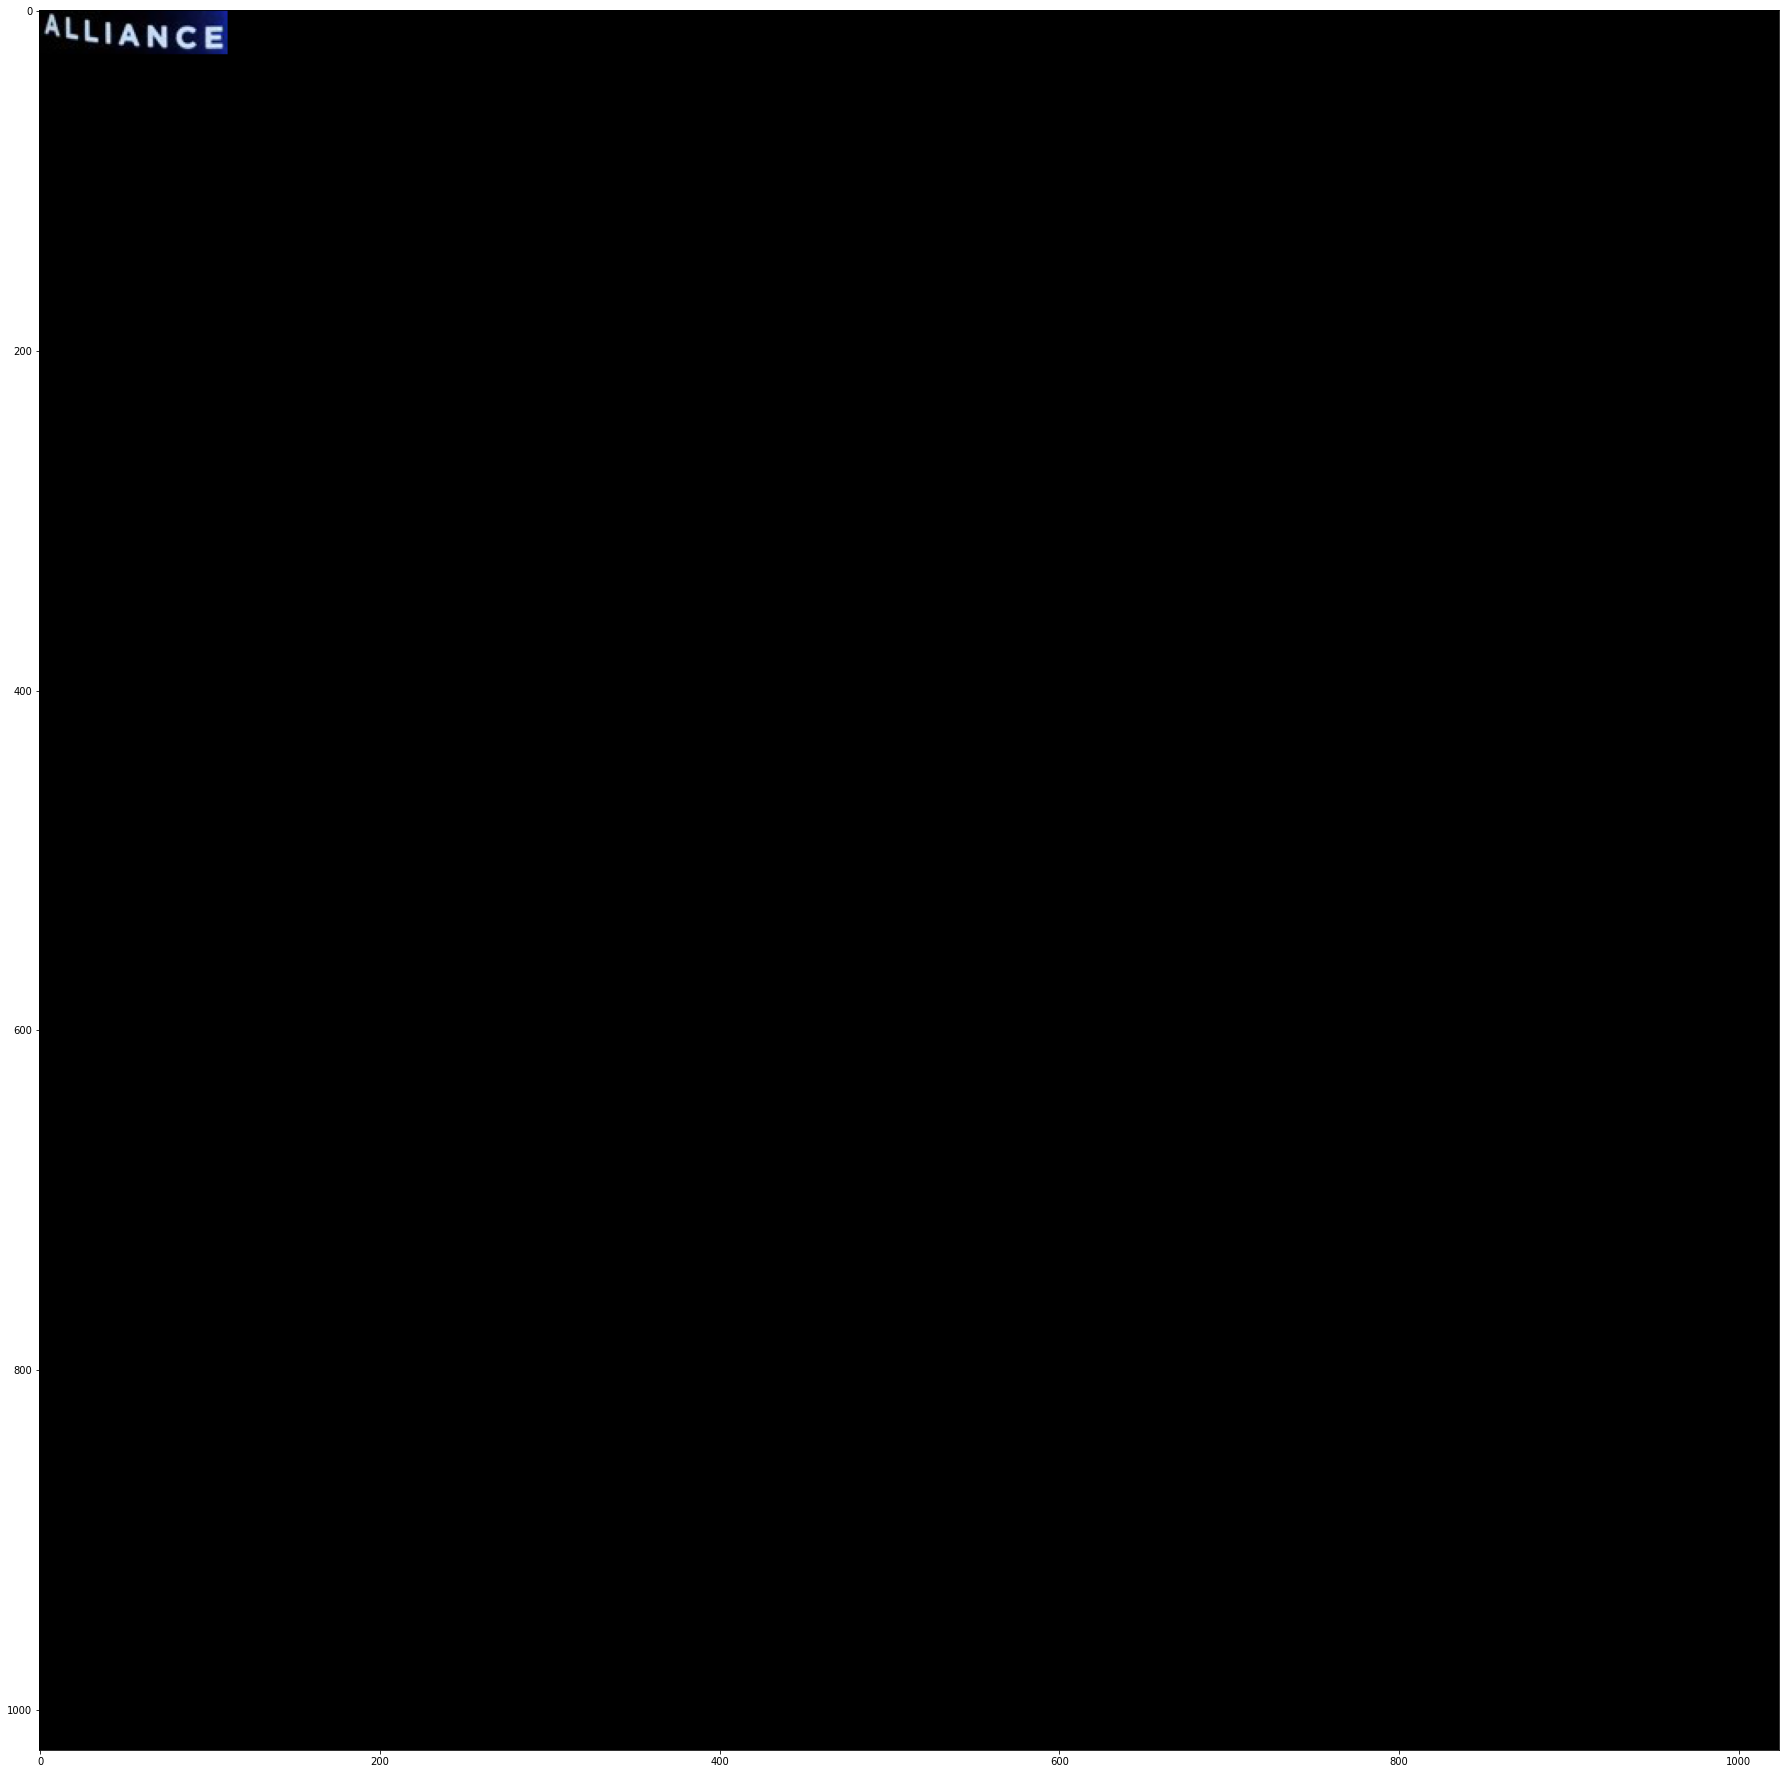

In [180]:
data = OCRdata.__getitem__(-1)

plt.figure(figsize=(32,32))
plt.imshow(data['image'])
print(data['text'])
print(data['int_text'])

In [171]:
#test
OCRdata.train_data.index.values[-1]

35683

In [172]:
###initialize data_loaders
tx_X = transforms.Compose([transforms.ToTensor(),
              transforms.Normalize((0.5,), (0.5,))])
tx_Y = transforms.Compose([transforms.ToTensor()
                        ])

# train_data = dset('/content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/', train=True, test=False, transformX = tx_X, transformY = tx_Y)
# validation_data = dset('/content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/', train=False,test=False,transformX = tx_X, transformY = tx_Y)
# test_data = dset('/content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/', train=False, test=True,transformX = tx_X, transformY = tx_Y
train_data = dset('/content/drive/MyDrive/CV_Final_Project_Data/data/', train=True, test=False, transformX = tx_X, transformY = tx_Y)
validation_data = dset('/content/drive/MyDrive/CV_Final_Project_Data/data/', train=False,test=False,transformX = tx_X, transformY = tx_Y)
test_data = dset('/content/drive/MyDrive/CV_Final_Project_Data/data/', train=False, test=True,transformX = tx_X, transformY = tx_Y)

train_loader = DataLoader(dataset=train_data, batch_size=2, shuffle=True, num_workers=2)
validation_loader = DataLoader(dataset=validation_data, batch_size=2, shuffle=True, num_workers=1)
test_loader = DataLoader(dataset=test_data, batch_size=2, shuffle=True, num_workers=1)

In [151]:
print('length')
print(len(train_loader))
print(len(validation_loader))
print(len(test_loader))

length
28003
20002
20003


#Model

In [181]:
import torch.nn as nn


class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))

    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # rnn features
        output = self.rnn(conv)

        return output

In [182]:
model = CRNN(1152, 3, 37, 256)
if torch.cuda.is_available():
    model = model.to('cuda')

In [183]:
model.modules

<bound method Module.modules of CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNo

#Loss and Optimizer

In [184]:
# Using Adam as our optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # weight_decay=

In [185]:
# Using Loss()
criterion = nn.CTCLoss()

#Train and Validation (TO DO)

In [135]:
torch.save(model.state_dict(),'/content/best_unet_051722_v1.pth')

# Train

In [187]:
import collections
class strLabelConverter(object):
    """Convert between str and label.
    NOTE:
        Insert `blank` to the alphabet for CTC.
    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet, ignore_case=True):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index

        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1

    def encode(self, text):
        """Support batch or single str.
        Args:
            text (str or list of str): texts to convert.
        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        if isinstance(text, str):
            text = [
                self.dict[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        elif isinstance(text, collections.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.
        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        Raises:
            AssertionError: when the texts and its length does not match.
        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
            return texts

In [193]:
def loadData(v, data):
  v.data.resize_(data.size()).copy_(data)
text = torch.IntTensor(64 * 5)
text = Variable(text)

In [194]:
# Training the model
def train(model, train_loader, validation_loader, optimizer, criterion, epochs):
    # Training the model
    model.train()
    train_loss = []
    validation_loss = []
    for epoch in range(epochs):
        print('Epoch: {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        running_loss = 0.0
        for i, item in enumerate(train_loader):
            batch_size = item['image'].size(0)
            print(batch_size)
            loadData(text, item['int_text'])
            print(i)
            print(item)
            if torch.cuda.is_available():
                inputs = item['image'].to('cuda')
                labels = torch.Variable(item['int_text']).to('cuda')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 10 == 9:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
                train_loss.append(running_loss / 10)
                running_loss = 0.0
        print('Training Loss: {}'.format(np.mean(train_loss)))
        # print('Validating...')
        # val_loss = 0.0
        # for i, (inputs, labels) in enumerate(validation_loader):
        #     if torch.cuda.is_available():
        #         inputs = item['image'].to('cuda')
        #         labels = item['int_text'].to('cuda')
        #     outputs = model(inputs)
        #     loss = criterion(outputs, labels)
        #     val_loss += loss.item()
        # print('Validation Loss: {}'.format(val_loss / len(validation_loader)))
        # validation_loss.append(val_loss / len(validation_loader))
        # if epoch % 10 == 9:
        #     torch.save(model.state_dict(),'/content/best_unet_051722_v1.pth')
    return train_loss, validation_loss

In [195]:
train_loss, validation_loss = train(model, train_loader, validation_loader, optimizer, criterion, 10)

Epoch: 1/10
----------
(1024, 650, 3)
(16, 38, 3)
(680, 1024, 3)
(17, 34, 3)


KeyError: ignored

# Test

Once the training is completed, we just need to upload the model and run from here.

In [ ]:
print('Avergae Dice Score is:',test_score)
print('Avergae Dice Loss is:',1-test_score)

#Post-Process